# Nuclear Morphology and Chromatin Feature Extraction

This notebook processes microscopy images to:
1. Filter out noise particles that aren't nuclei
2. Extract comprehensive nuclear features from all valid nuclei
3. Save the features to a CSV file for further analysis

In [1]:
# Import libraries
%load_ext autoreload
import sys
sys.path.append("../")

from tifffile import imread, imsave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from datetime import datetime
from skimage import measure, morphology, segmentation

from nmco.nuclear_features import (
    global_morphology as BG,
    img_texture as IT,
    int_dist_features as IDF,
    boundary_local_curvature as BLC
)

from tqdm.notebook import tqdm  # For progress bars

## Load Input Images

Provide the paths to your raw intensity image and segmentation mask.

In [2]:
# Define image paths - modify these as needed
labelled_image_path = os.path.join(os.path.dirname(os.getcwd()), 'example_data/009_G11_segmented.tif')
raw_image_path = os.path.join(os.path.dirname(os.getcwd()), 'example_data/009_G11_raw.tif')

# Output folder for saving results
output_folder = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(output_folder, exist_ok=True)

# Load the images
labelled_image = imread(labelled_image_path).astype(int)
raw_image = imread(raw_image_path).astype(int)

# Normalize raw image intensity
raw_image = cv.normalize(raw_image, None, alpha=0, beta=150, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

## Preprocess the Segmentation Mask

Convert binary mask to proper labeled image and visualize it.

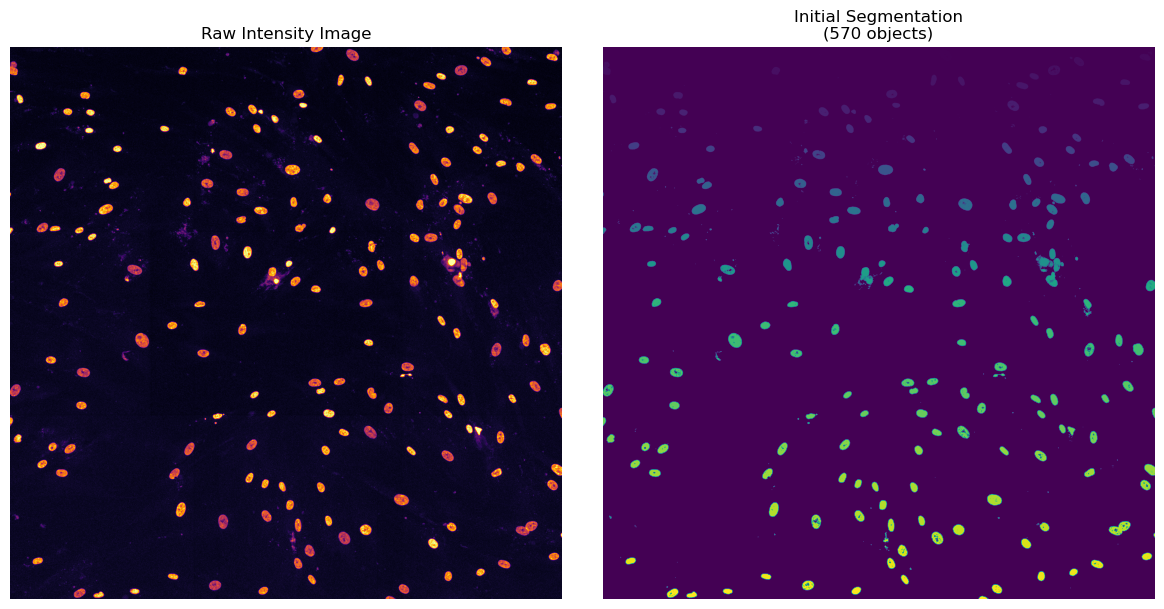

In [3]:
# Convert binary mask (0,255) → Labeled Image (1,2,3,...)
binary_mask = labelled_image > 0
labelled_image = measure.label(binary_mask, connectivity=2)

# Display the raw and labeled images
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.imshow(raw_image, cmap='inferno')
ax0.set_title("Raw Intensity Image")
ax0.axis('off')

ax1.imshow(labelled_image, cmap='viridis')
ax1.set_title(f"Initial Segmentation\n({labelled_image.max()} objects)")
ax1.axis('off')

plt.tight_layout()
plt.show()

## Filter Out Non-Nuclear Objects

Remove small particles and other noise that aren't true nuclei.

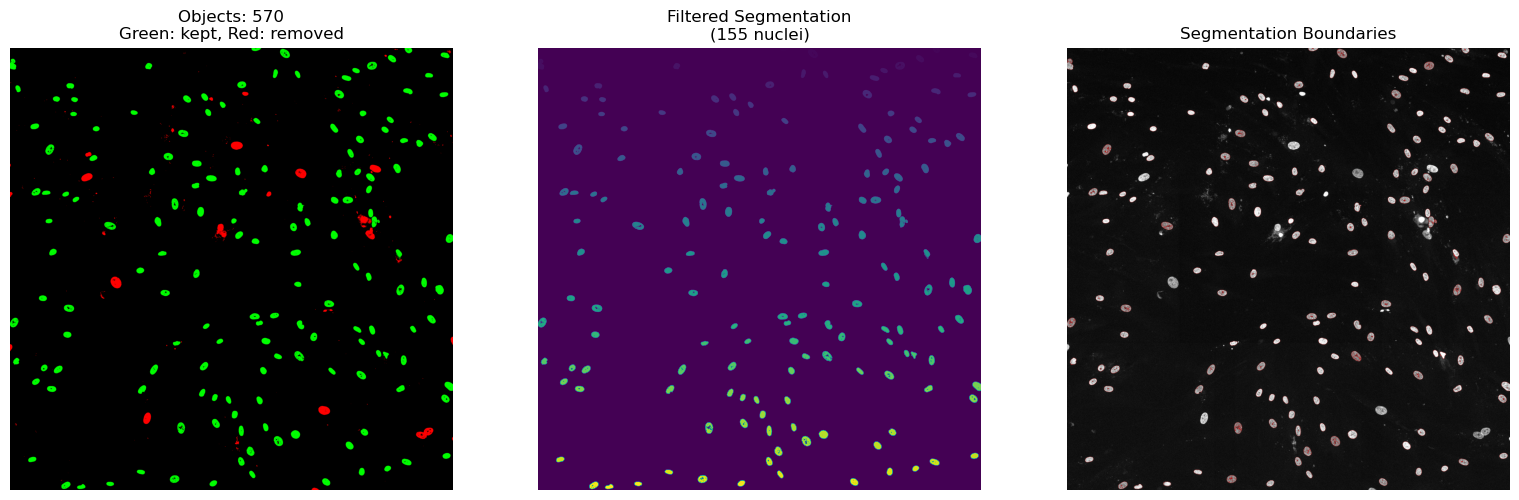

Before filtering: 570 objects
After filtering: 155 nuclei
Removed: 415 objects


In [4]:
# Set thresholds for filtering
MIN_NUCLEUS_AREA = 4000  # Minimum area in pixels to be considered a nucleus
MAX_NUCLEUS_AREA = 12000  # Maximum area to exclude giant clumps/artifacts
MAX_ECCENTRICITY = 2.9   # Maximum eccentricity to exclude extremely elongated objects

# Get region properties
props_all = measure.regionprops(labelled_image, intensity_image=raw_image)

# Create a mask for valid nuclei
valid_nuclei_mask = np.zeros_like(labelled_image, dtype=bool)
valid_labels = []
invalid_labels = []

for prop in props_all:
    if MIN_NUCLEUS_AREA <= prop.area <= MAX_NUCLEUS_AREA and prop.eccentricity < MAX_ECCENTRICITY:
        # Additional filtering based on solidity if needed
        #if prop.solidity > 0.8:  # Objects should be reasonably solid/filled
        valid_nuclei_mask[tuple(prop.coords.T)] = True
        valid_labels.append(prop.label)
    else:
        invalid_labels.append(prop.label)

# Relabel the filtered mask
filtered_labelled_image = measure.label(valid_nuclei_mask)

# Visualize the filtering results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original labeled image with color-coded filtering
overlay = np.zeros((*labelled_image.shape, 3))
for prop in props_all:
    if prop.label in valid_labels:
        # Valid nuclei in green
        overlay[labelled_image == prop.label] = [0, 1, 0]  
    else:
        # Invalid objects in red
        overlay[labelled_image == prop.label] = [1, 0, 0]  

axes[0].imshow(overlay)
axes[0].set_title(f'Objects: {len(props_all)}\nGreen: kept, Red: removed')
axes[0].axis('off')

# Filtered labeled image
axes[1].imshow(filtered_labelled_image, cmap='viridis')
axes[1].set_title(f'Filtered Segmentation\n({len(valid_labels)} nuclei)')
axes[1].axis('off')

# Show boundaries on raw image
boundaries = segmentation.find_boundaries(filtered_labelled_image)
rgb_raw = np.dstack([raw_image/raw_image.max()]*3)  # Convert to RGB
rgb_raw[boundaries] = [1, 0, 0]  # Red boundaries

axes[2].imshow(rgb_raw)
axes[2].set_title('Segmentation Boundaries')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Before filtering: {len(props_all)} objects")
print(f"After filtering: {len(valid_labels)} nuclei")
print(f"Removed: {len(invalid_labels)} objects")

# Update our labeled image with the filtered version
labelled_image = filtered_labelled_image.copy()

## Size Distribution Analysis

Visualize the size distribution of the filtered nuclei.

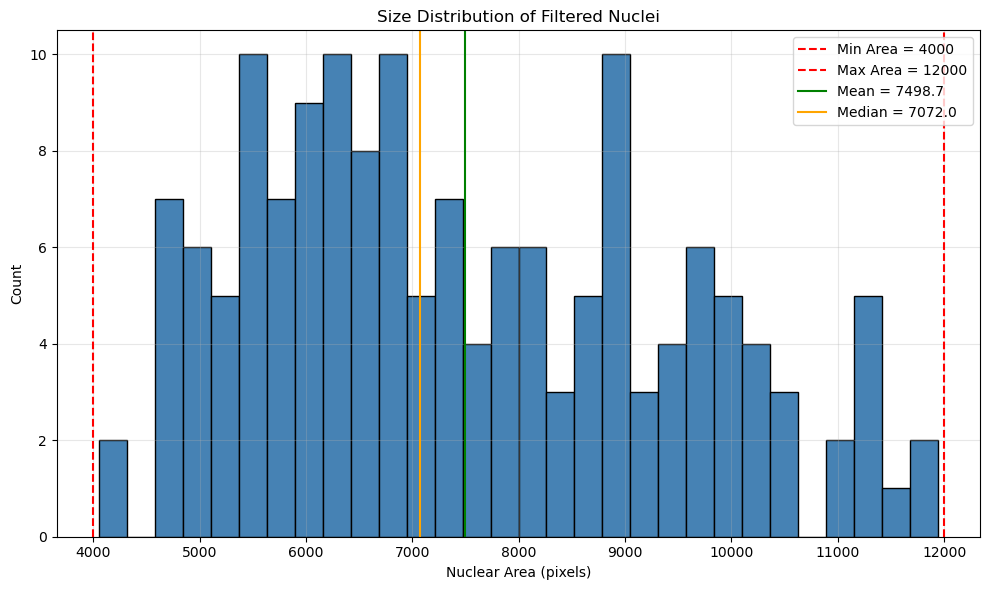

In [5]:
# Get region properties for the filtered image
props = measure.regionprops(labelled_image, intensity_image=raw_image)

# Extract nuclei areas
areas = [prop.area for prop in props]

# Plot size distribution
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=30, color='steelblue', edgecolor='black')
plt.title('Size Distribution of Filtered Nuclei')
plt.xlabel('Nuclear Area (pixels)')
plt.ylabel('Count')
plt.axvline(MIN_NUCLEUS_AREA, color='red', linestyle='--', label=f'Min Area = {MIN_NUCLEUS_AREA}')
plt.axvline(MAX_NUCLEUS_AREA, color='red', linestyle='--', label=f'Max Area = {MAX_NUCLEUS_AREA}')
plt.axvline(np.mean(areas), color='green', linestyle='-', label=f'Mean = {np.mean(areas):.1f}')
plt.axvline(np.median(areas), color='orange', linestyle='-', label=f'Median = {np.median(areas):.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Extraction Function

Define a function to extract all features from a single nucleus.

In [6]:
def extract_nucleus_features(nucleus_properties):
    """
    Extract all features for a single nucleus
    
    Args:
        nucleus_properties: Properties of a single nucleus from regionprops
        
    Returns:
        DataFrame row with all the features for this nucleus
    """
    # Get binary mask and intensity image
    binary_mask = nucleus_properties.image
    intensity_img = nucleus_properties.intensity_image
    
    # Initialize features dictionary with the nucleus label
    features_dict = {'label': nucleus_properties.label}
    
    try:
        # 1. Basic regionprops features
        regionprops_features = {
            'area': nucleus_properties.area,
            'perimeter': nucleus_properties.perimeter,
            'eccentricity': nucleus_properties.eccentricity,
            'solidity': nucleus_properties.solidity,
            'equivalent_diameter': nucleus_properties.equivalent_diameter,
            'major_axis_length': nucleus_properties.major_axis_length,
            'minor_axis_length': nucleus_properties.minor_axis_length,
            'orientation': nucleus_properties.orientation,
        }
        features_dict.update(regionprops_features)
        
        # 2. Global morphology features
        morphology_features = BG.measure_global_morphometrics(binary_mask)
        features_dict.update(morphology_features.to_dict())
        
        # 3. Local boundary curvature features (use smaller step for small nuclei)
        step_size = 5 if nucleus_properties.area > 500 else 3
        curvature_features = BLC.measure_curvature_features(binary_mask, step=step_size)
        features_dict.update(curvature_features.to_dict())
        
        # 4. Intensity distribution features
        intensity_features = IDF.measure_intensity_features(binary_mask, intensity_img)
        features_dict.update(intensity_features.to_dict())
        
        # 5. Texture features
        texture_features = IT.measure_texture_features(binary_mask, intensity_img)
        features_dict.update(texture_features.to_dict())
        
        # Create dataframe from the dictionary
        return pd.DataFrame([features_dict])
        
    except Exception as e:
        print(f"Error processing nucleus {nucleus_properties.label}: {str(e)}")
        return None

## Process All Nuclei

Extract features from all valid nuclei in the image.

In [7]:
# Get region properties for the filtered image
from tqdm import tqdm 
props = measure.regionprops(labelled_image, intensity_image=raw_image)

# Initialize empty dataframe for all nuclei features
all_nuclei_features = pd.DataFrame()

# Process each nucleus with a progress bar
print(f"Extracting features from {len(props)} nuclei...")

for i, prop in enumerate(tqdm(props)):
    # Extract features for this nucleus
    nucleus_features = extract_nucleus_features(prop)
    
    # If successful, add to the master dataframe
    if nucleus_features is not None:
        all_nuclei_features = pd.concat([all_nuclei_features, nucleus_features], ignore_index=True)
    
    # Optional: Display progress update every 20 nuclei
    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(props)} nuclei")

print(f"Successfully extracted features from {len(all_nuclei_features)} nuclei")

Extracting features from 155 nuclei...


 13%|█████████▏                                                             | 20/155 [00:03<00:23,  5.70it/s]

Processed 20/155 nuclei


 26%|██████████████████▊                                                    | 41/155 [00:07<00:21,  5.35it/s]

Processed 40/155 nuclei


 39%|███████████████████████████▉                                           | 61/155 [00:11<00:18,  5.04it/s]

Processed 60/155 nuclei


 52%|█████████████████████████████████████                                  | 81/155 [00:15<00:15,  4.72it/s]

Processed 80/155 nuclei


 65%|█████████████████████████████████████████████▌                        | 101/155 [00:20<00:10,  4.92it/s]

Processed 100/155 nuclei


 77%|██████████████████████████████████████████████████████▏               | 120/155 [00:24<00:07,  4.63it/s]

Processed 120/155 nuclei


 90%|███████████████████████████████████████████████████████████████▏      | 140/155 [00:28<00:03,  4.06it/s]

Processed 140/155 nuclei


100%|██████████████████████████████████████████████████████████████████████| 155/155 [00:31<00:00,  4.90it/s]

Successfully extracted features from 155 nuclei


## Save Results to CSV

Save the extracted features to a CSV file.

In [8]:
# Generate filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_filename = os.path.basename(raw_image_path).split('.')[0]
csv_filename = f"{base_filename}_features_{timestamp}.csv"
csv_path = os.path.join(output_folder, csv_filename)

# Save to CSV
all_nuclei_features.to_csv(csv_path, index=False)
print(f"Features saved to: {csv_path}")

# Display summary of the features
print(f"\nFeature set contains {len(all_nuclei_features)} nuclei with {len(all_nuclei_features.columns)} features per nucleus")
print(f"\nFeature categories:")
print(f"Basic regionprops features: area, perimeter, eccentricity, etc.")
print(f"Global morphology features: caliper_length, sphericity, etc.")
print(f"Boundary curvature features: curvature_mean, curvature_std, etc.")
print(f"Intensity features: median_intensity, hetero_ratio, etc.")
print(f"Texture features: glcm_contrast, glcm_correlation, etc.")

Features saved to: D:\Acad 3 - 2\Project\chrometrics\results\009_G11_raw_features_20250403_091621.csv

Feature set contains 155 nuclei with 202 features per nucleus

Feature categories:
Basic regionprops features: area, perimeter, eccentricity, etc.
Global morphology features: caliper_length, sphericity, etc.
Boundary curvature features: curvature_mean, curvature_std, etc.
Intensity features: median_intensity, hetero_ratio, etc.
Texture features: glcm_contrast, glcm_correlation, etc.


Pipelined Nuclear Feature Extraction and saving each image as a CSV.


In [9]:
# -*- coding: utf-8 -*-
"""Full_Nuclear_Feature_Extraction_Pipeline.py

This script processes all microscopy image pairs in a directory to:
1. Filter out noise particles that aren't nuclei
2. Extract comprehensive nuclear features from all valid nuclei
3. Save the features to CSV files for further analysis
"""

# Import libraries
import sys
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tifffile import imread
from skimage import measure, segmentation
from tqdm import tqdm

# Import feature extraction modules
from nmco.nuclear_features import (
    global_morphology as BG,
    img_texture as IT,
    int_dist_features as IDF,
    boundary_local_curvature as BLC
)

# Configuration parameters
MIN_NUCLEUS_AREA = 4000  # Minimum area in pixels to be considered a nucleus
MAX_NUCLEUS_AREA = 14000  # Maximum area to exclude giant clumps/artifacts
MAX_ECCENTRICITY = 2.9   # Maximum eccentricity to exclude extremely elongated objects

def extract_nucleus_features(nucleus_properties):
    """
    Extract all features for a single nucleus

    Args:
        nucleus_properties: Properties of a single nucleus from regionprops

    Returns:
        DataFrame row with all the features for this nucleus
    """
    # Get binary mask and intensity image
    binary_mask = nucleus_properties.image
    intensity_img = nucleus_properties.intensity_image

    # Initialize features dictionary with the nucleus label
    features_dict = {'label': nucleus_properties.label}

    try:
        # 1. Basic regionprops features
        regionprops_features = {
            'area': nucleus_properties.area,
            'perimeter': nucleus_properties.perimeter,
            'eccentricity': nucleus_properties.eccentricity,
            'solidity': nucleus_properties.solidity,
            'equivalent_diameter': nucleus_properties.equivalent_diameter,
            'major_axis_length': nucleus_properties.major_axis_length,
            'minor_axis_length': nucleus_properties.minor_axis_length,
            'orientation': nucleus_properties.orientation,
        }
        features_dict.update(regionprops_features)

        # 2. Global morphology features
        morphology_features = BG.measure_global_morphometrics(binary_mask)
        features_dict.update(morphology_features.to_dict())

        # 3. Local boundary curvature features (use smaller step for small nuclei)
        step_size = 5 if nucleus_properties.area > 500 else 3
        curvature_features = BLC.measure_curvature_features(binary_mask, step=step_size)
        features_dict.update(curvature_features.to_dict())

        # 4. Intensity distribution features
        intensity_features = IDF.measure_intensity_features(binary_mask, intensity_img)
        features_dict.update(intensity_features.to_dict())

        # 5. Texture features
        texture_features = IT.measure_texture_features(binary_mask, intensity_img)
        features_dict.update(texture_features.to_dict())

        # Create dataframe from the dictionary
        return pd.DataFrame([features_dict])

    except Exception as e:
        print(f"Error processing nucleus {nucleus_properties.label}: {str(e)}")
        return None

def process_image_pair(raw_image_path, labelled_image_path, output_folder):
    """
    Process a single pair of raw and segmented images
    
    Args:
        raw_image_path: Path to the raw intensity image
        labelled_image_path: Path to the segmentation mask
        output_folder: Folder to save results
        
    Returns:
        Path to the saved CSV file
    """
    print(f"\nProcessing image pair: {os.path.basename(raw_image_path)} & {os.path.basename(labelled_image_path)}")
    
    # Load the images
    labelled_image = imread(labelled_image_path).astype(int)
    raw_image = imread(raw_image_path).astype(int)

    # Normalize raw image intensity
    raw_image = cv.normalize(raw_image, None, alpha=0, beta=150, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

    # Convert binary mask (0,255) → Labeled Image (1,2,3,...)
    binary_mask = labelled_image > 0
    labelled_image = measure.label(binary_mask, connectivity=2)
    
    print(f"Initial segmentation contains {labelled_image.max()} objects")
    
    # Filter out non-nuclear objects
    props_all = measure.regionprops(labelled_image, intensity_image=raw_image)
    
    # Create a mask for valid nuclei
    valid_nuclei_mask = np.zeros_like(labelled_image, dtype=bool)
    valid_labels = []
    invalid_labels = []

    for prop in props_all:
        if MIN_NUCLEUS_AREA <= prop.area <= MAX_NUCLEUS_AREA and prop.eccentricity < MAX_ECCENTRICITY:
            valid_nuclei_mask[tuple(prop.coords.T)] = True
            valid_labels.append(prop.label)
        else:
            invalid_labels.append(prop.label)

    # Relabel the filtered mask
    filtered_labelled_image = measure.label(valid_nuclei_mask)
    
    print(f"Before filtering: {len(props_all)} objects")
    print(f"After filtering: {len(valid_labels)} nuclei")
    print(f"Removed: {len(invalid_labels)} objects")
    
    # Update our labeled image with the filtered version
    labelled_image = filtered_labelled_image.copy()
    
    # Get region properties for the filtered image
    props = measure.regionprops(labelled_image, intensity_image=raw_image)
    
    # Initialize empty dataframe for all nuclei features
    all_nuclei_features = pd.DataFrame()
    
    # Process each nucleus with a progress bar
    print(f"Extracting features from {len(props)} nuclei...")
    
    for i, prop in enumerate(tqdm(props)):
        # Extract features for this nucleus
        nucleus_features = extract_nucleus_features(prop)

        # If successful, add to the master dataframe
        if nucleus_features is not None:
            all_nuclei_features = pd.concat([all_nuclei_features, nucleus_features], ignore_index=True)

    print(f"Successfully extracted features from {len(all_nuclei_features)} nuclei")
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_filename = os.path.basename(raw_image_path).split('.')[0]
    csv_filename = f"{base_filename}_features_{timestamp}.csv"
    csv_path = os.path.join(output_folder, csv_filename)

    # Save to CSV
    all_nuclei_features.to_csv(csv_path, index=False)
    print(f"Features saved to: {csv_path}")
    
    return csv_path

def find_image_pairs(data_folder):
    """
    Find all pairs of raw and segmented images in the data folder
    
    Args:
        data_folder: Folder containing the images
        
    Returns:
        List of tuples (raw_path, segmented_path)
    """
    # Get all TIFF files in the folder
    all_files = [f for f in os.listdir(data_folder) if f.endswith('.tif')]
    
    # Separate raw and segmented files
    raw_files = [f for f in all_files if '_raw.tif' in f]
    segmented_files = [f for f in all_files if '_segmented.tif' in f]
    
    # Create pairs based on matching base names
    pairs = []
    for raw_file in raw_files:
        # Extract the base name (e.g., "009_G11" from "009_G11_raw.tif")
        base_name = raw_file.replace('_raw.tif', '')
        segmented_file = f"{base_name}_segmented.tif"
        
        if segmented_file in segmented_files:
            raw_path = os.path.join(data_folder, raw_file)
            segmented_path = os.path.join(data_folder, segmented_file)
            pairs.append((raw_path, segmented_path))
    
    return pairs

def main():
    """Main function to run the pipeline"""
    # Define input and output folders
    data_folder = os.path.join(os.path.dirname(os.getcwd()), 'DataSamples/')
    output_folder = os.path.join(os.path.dirname(os.getcwd()), 'results/wash')
    os.makedirs(output_folder, exist_ok=True)
    
    # Find all image pairs
    image_pairs = find_image_pairs(data_folder)
    print(f"Found {len(image_pairs)} image pairs to process")
    
    # Process each pair
    results = []
    for i, (raw_path, segmented_path) in enumerate(image_pairs):
        print(f"\n[{i+1}/{len(image_pairs)}] Processing pair: {os.path.basename(raw_path)}")
        try:
            csv_path = process_image_pair(raw_path, segmented_path, output_folder)
            results.append({
                'raw_image': os.path.basename(raw_path),
                'segmented_image': os.path.basename(segmented_path),
                'status': 'Success',
                'output': os.path.basename(csv_path)
            })
        except Exception as e:
            print(f"Error processing {os.path.basename(raw_path)}: {str(e)}")
            results.append({
                'raw_image': os.path.basename(raw_path),
                'segmented_image': os.path.basename(segmented_path),
                'status': 'Failed',
                'error': str(e)
            })
    
    # Save summary report
    report_df = pd.DataFrame(results)
    report_path = os.path.join(output_folder, f"processing_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    report_df.to_csv(report_path, index=False)
    
    print(f"\nPipeline completed. Processed {len(results)} image pairs.")
    print(f"Summary report saved to: {report_path}")
    
    # Display summary
    successful = sum(1 for r in results if r['status'] == 'Success')
    failed = sum(1 for r in results if r['status'] == 'Failed')
    print(f"\nSuccessful: {successful}, Failed: {failed}")

if __name__ == "__main__":
    main()

Found 5 image pairs to process

[1/5] Processing pair: 104_L6_raw.tif

Processing image pair: 104_L6_raw.tif & 104_L6_segmented.tif
Initial segmentation contains 318 objects
Before filtering: 318 objects
After filtering: 7 nuclei
Removed: 311 objects
Extracting features from 7 nuclei...


100%|███████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.14it/s]


Successfully extracted features from 7 nuclei
Features saved to: D:\Acad 3 - 2\Project\chrometrics\results/wash\104_L6_raw_features_20250403_091829.csv

[2/5] Processing pair: 105_L7_raw.tif

Processing image pair: 105_L7_raw.tif & 105_L7_segmented.tif
Initial segmentation contains 289 objects
Before filtering: 289 objects
After filtering: 10 nuclei
Removed: 279 objects
Extracting features from 10 nuclei...


100%|█████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


Successfully extracted features from 10 nuclei
Features saved to: D:\Acad 3 - 2\Project\chrometrics\results/wash\105_L7_raw_features_20250403_091836.csv

[3/5] Processing pair: 106_L8_raw.tif

Processing image pair: 106_L8_raw.tif & 106_L8_segmented.tif
Initial segmentation contains 353 objects
Before filtering: 353 objects
After filtering: 7 nuclei
Removed: 346 objects
Extracting features from 7 nuclei...


100%|███████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.18it/s]


Successfully extracted features from 7 nuclei
Features saved to: D:\Acad 3 - 2\Project\chrometrics\results/wash\106_L8_raw_features_20250403_091841.csv

[4/5] Processing pair: 107_L9_raw.tif

Processing image pair: 107_L9_raw.tif & 107_L9_segmented.tif
Initial segmentation contains 322 objects
Before filtering: 322 objects
After filtering: 1 nuclei
Removed: 321 objects
Extracting features from 1 nuclei...


100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Successfully extracted features from 1 nuclei
Features saved to: D:\Acad 3 - 2\Project\chrometrics\results/wash\107_L9_raw_features_20250403_091844.csv

[5/5] Processing pair: 108_L10_raw.tif

Processing image pair: 108_L10_raw.tif & 108_L10_segmented.tif
Initial segmentation contains 350 objects
Before filtering: 350 objects
After filtering: 10 nuclei
Removed: 340 objects
Extracting features from 10 nuclei...


100%|█████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.27it/s]

Successfully extracted features from 10 nuclei
Features saved to: D:\Acad 3 - 2\Project\chrometrics\results/wash\108_L10_raw_features_20250403_091850.csv

Pipeline completed. Processed 5 image pairs.
Summary report saved to: D:\Acad 3 - 2\Project\chrometrics\results/wash\processing_report_20250403_091850.csv

Successful: 5, Failed: 0
